In [1]:
import numpy as np
import pandas as pd
import os 
import sys
from scipy.optimize import curve_fit
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import ticker as mticker
%matplotlib inline
import glob
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def split_NHVecs(nhvecs, dt, tau):
    """
    This function will split the trajectory in chuncks based off tau_m or tau memory i.e. the memory of the 
    """
    nFiles = len(nhvecs)
    nFramesPerChunk = int(tau/dt) ###tau/timestep 
    used_frames = np.zeros(nFiles,dtype=int)
    remainingFrames = np.zeros(nFiles,dtype=int)
    for i in range(nFiles):
        nFrames = nhvecs[i].shape[0]
        used_frames[i] = int(nFrames/nFramesPerChunk)*nFramesPerChunk
        remainingFrames[i] = nFrames % nFramesPerChunk

    nFramesTot=int(used_frames.sum())
    out = np.zeros((nFramesTot,NHVecs[0].shape[1],NHVecs[0].shape[2]), dtype=NHVecs[0].dtype)
    start = 0
    for i in range(nFiles):
        end = int(start+used_frames[i])
        endv = int(used_frames[i])
        out[start:end,...] = nhvecs[i][0:endv,...]
        start = end

    sh = out.shape
    vecs = out.reshape((int(nFramesTot/nFramesPerChunk), nFramesPerChunk, sh[-2], sh[-1]))

    return vecs

In [3]:
def _bound_check(func, params):
    """
    Checks if the fit returns a sum of the amplitudes greater than 1.
    """
    if len(params) == 1:
        return False
    elif len(params) %2 == 0 :
        s = sum(params[0::2])
        return (s>1)
    else:
        s = params[0]+sum(params[1::2])
        return (s>1)

In [4]:
def calc_chi(y1, y2, dy=[]):
    """
    calculates the chi^2 difference between the predicted model and the actual data
    """
    if dy != []:
        return np.sum( (y1-y2)**2.0/dy )/len(y1)
    else:
        return np.sum( (y1-y2)**2.0 )/len(y1)


In [5]:
def func_exp_decay1(t, tau_a):
    return np.exp(-t/tau_a)
def func_exp_decay2(t, A, tau_a):
    return A*np.exp(-t/tau_a)
def func_exp_decay3(t, A, tau_a, tau_b):
    return A*np.exp(-t/tau_a) + (1-A)*np.exp(-t/tau_b)
def func_exp_decay4(t, A, tau_a, B, tau_b ):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b)
def func_exp_decay5(t, A, tau_a, B, tau_b, tau_g ):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + (1-A-B)*np.exp(-t/tau_g)
def func_exp_decay6(t, A, tau_a, B, tau_b, G, tau_g ):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g)
def func_exp_decay7(t, A, tau_a, B, tau_b, G, tau_g, tau_d):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g) + (1-A-B-G)*np.exp(-t/tau_d)
def func_exp_decay8(t, A, tau_a, B, tau_b, G, tau_g, D, tau_d):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g) + D*np.exp(-t/tau_d)
def func_exp_decay9(t, A, tau_a, B, tau_b, G, tau_g, D, tau_d, tau_e):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g) + D*np.exp(-t/tau_d) + (1-A-B-G-D)*np.exp(-t/tau_e)
def func_exp_decay10(t, A, tau_a, B, tau_b, G, tau_g, D, tau_d, E, tau_e):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g) + D*np.exp(-t/tau_d) + E*np.exp(-t/tau_e)

In [6]:
def _return_parameter_names(num_pars):
    """
    Function that returns the names of the parameters for writing to the dataframe after the fit.
    num_pars is the number of parameters in the fit. 1,3,5,7,9 are the num_params that constrain the fit.
    while the even numbers are the parameters for the functions that don't constrain the fits.
    """
    if num_pars==1:
        return  ['C_a', 'tau_a']
    elif num_pars==2:
         return ['C_a', 'tau_a']
    elif num_pars==3:
         return ['C_a', 'tau_a', 'tau_b']
    elif num_pars==4:
         return ['C_a', 'tau_a', 'C_b', 'tau_b']
    elif num_pars==5:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'tau_g']
    elif num_pars==6:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g']
    elif num_pars==7:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g', 'tau_d']
    elif num_pars==8:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g', 'C_d', 'tau_d']
    elif num_pars==9:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g', 'C_d', 'tau_d', 'tau_e']
    elif num_pars==10:
         return [ 'C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g', 'C_d', 'tau_d', 'C_e', 'tau_e']


In [7]:
def do_Expstyle_fit2(num_pars, x, y, dy=np.empty([]), tau_mem=50.):
    """
    Performs the exponential fit on the function defined by num_pars using scipy optimize curve fit.
    Provides initial guesses for the amplitudes and the correlation times.
    Takes the number of parameters, x values, y values, error in the y (dy), and tau_mem.
    Tau_mem is the maximum tau that the correlation times can take, which bound the fit.
    Can also be set to np.inf if you want no bounds. 
    
    Returns, the Chi-squared value of the fit to the model along with the parameter values (popt),
    the parameter error (popv) and the model itself.
    """

    b1_guess = y[0]/num_pars/2
    t1_guess = [tau_mem/1280.0, tau_mem/640.0, tau_mem/64.0, tau_mem/8.0]

    if num_pars==1:
        func=func_exp_decay1
        guess=(t1_guess[2])
        bound=(0.,np.inf)
    elif num_pars==2:
        func=func_exp_decay2
        guess=(b1_guess, t1_guess[2])
        bound=([0.0, x[0]],[1., tau_mem])
    elif num_pars==3:
        func=func_exp_decay3
        guess=(b1_guess, t1_guess[3], t1_guess[2])
        bound=([0.0,x[0],x[0]],[1., tau_mem, tau_mem])
    elif num_pars==4:
        func=func_exp_decay4
        guess=(b1_guess, t1_guess[3], b1_guess, t1_guess[2])
        bound=([0.0, x[0], 0.0, x[0]],[1., tau_mem, 1., tau_mem])
    elif num_pars==5:
        func=func_exp_decay5
        guess=(b1_guess, t1_guess[3], b1_guess, t1_guess[2], t1_guess[1])
        bound=([0.0, x[0], 0.0, x[0],x[0]],[1., tau_mem, 1., tau_mem, tau_mem])
    elif num_pars==6:
        func=func_exp_decay6
        guess=(b1_guess, t1_guess[3], b1_guess, t1_guess[2], b1_guess, t1_guess[1])
        #bound=([0.0, x[0], 0.0, x[0], 0.0, x[0]],[1., tau_mem, 1., tau_mem, 1., tau_mem])
        bound=([0.0, x[0], 0.0, x[0], 0.0, x[0]],[1., np.inf, 1., np.inf, 1., np.inf])
    elif num_pars==7:
        func=func_exp_decay7
        guess=(b1_guess, t1_guess[2], b1_guess, t1_guess[1], b1_guess, t1_guess[0],
               t1_guess[3])
        bound=([0.0, x[0], 0.0, x[0], 0.0, x[0], x[0]],[1., tau_mem, 1., tau_mem, 1., tau_mem, tau_mem])
    elif num_pars==8:
        func=func_exp_decay8
        guess=(b1_guess, t1_guess[3], b1_guess, t1_guess[2], b1_guess, t1_guess[1],
               b1_guess, t1_guess[0])

    #if dy != []:
     #   popt, popv = curve_fit(func, x, y, p0=guess, sigma=dy, bounds=bound, method='trf', loss='soft_l1')
    #else:
    popt, popv = curve_fit(func, x, y, p0=guess, bounds=bound, loss='soft_l1')

    ymodel=[ func(x[i], *popt) for i in range(len(x)) ]
    #print ymodel

    bExceed=_bound_check(func, popt)
    if bExceed:
        print >> sys.stderr, "= = = WARNING, curve fitting in do_LSstyle_fit returns a sum>1.//"
        return 9999.99, popt, np.sqrt(np.diag(popv)), ymodel
    else:
        return calc_chi(y, ymodel, dy), popt, popv, ymodel

In [8]:
def fitCorrF(CorrDF, dCorrDF, tau_mem, pars_l, fixfit):
    """
        Main function to fit the correlation function. 
        Loops over all residues with N-H vectors and calculates the fit, appends the best fit from findbest_Expstyle_fits2.
        Passes the set of lists to fitstoDF to return a data frame of the best fits for each residue. 
        
        Takes the correlation function CorrDF and errors in the correlation function, maximum tau mem to cut correlation
        function off from, the list of parameters you want to fit too. If you don't want to test the fit and use 
        a fixed parameter set, set fixfit to True and pass a list of length 1 into pars_l.
    """
    NH_Res = CorrDF.columns
    chi_list=[] ; names_list=[] ; pars_list=[] ; errs_list=[] ; ymodel_list=[]; covarMat_list = [];
    for i in CorrDF.columns:

        tstop = np.where(CorrDF.index.values==tau_mem)[0][0]

        x = CorrDF.index.values[:tstop]
        y = CorrDF[i].values[:tstop] #CorrDF[i].values[:tstop]
        dy = dCorrDF[i].values[:tstop]

        ## if not fixfit then find find the best expstyle fit. Otherwise force the fit to nparams 
        if (not fixfit)&(len(pars_l)>1):
            print("Finding the best fit for residue {}".format(i))

            chi, names, pars, errs, ymodel, covarMat = findbest_Expstyle_fits2(x, y, tau_mem, dy,
                                                            par_list=pars_l, threshold=thresh)

        elif (fixfit)&(len(pars_l)==1):
            print("Performing a fixed fit for {} exponentials".format(int(pars_l[0]/2)))

            chi, pars, covarMat, ymodel = do_Expstyle_fit2(pars_l[0], x, y, dy, tau_mem)
            names = _return_parameter_names(len(pars))
            errs = np.sqrt(np.diag(covarMat))

        else:
            print("The list of parameters is empty. Breaking out.")
            break;

        chi_list.append(chi)
        names_list.append(names)
        pars_list.append(pars)
        errs_list.append(errs)
        ymodel_list.append(ymodel)
        covarMat_list.append(covarMat)

    FitDF = fitstoDF(NH_Res, chi_list, pars_list, errs_list, names_list)

    return FitDF, covarMat_list



In [9]:
def fitstoDF(resnames, chi_list, pars_list, errs_list, names_list):
    ## Set Up columns indices and names for the data frame
    """
    Function that takes the residue names, chi^2, parameters, errors and names of the fits and returns a data frame
    of the parameters.
    """
    mparnames = _return_parameter_names(8)
    mtau_names = np.array(mparnames)[1::2]
    mc_names = np.array(mparnames)[::2]
    colnames = np.array(['Resname','NumExp'])
    tau_errnames = np.array([[c,"{}_err".format(c)] for c in mtau_names]).flatten()
    mc_errnames = np.array([[c, "{}_err".format(c)] for c in mc_names]).flatten()
    colnames = np.hstack([colnames,mc_errnames])
    colnames = np.hstack([colnames,tau_errnames])
    colnames = np.hstack([colnames,np.array(['Chi_Fit'])])
    FitDF = pd.DataFrame(index=np.arange(len(pars_list)), columns=colnames).fillna(0.0)
    FitDF['Resname'] = resnames
    FitDF['Chi_Fit'] = chi_list

    for i in range(len(pars_list)):
        npar = len(pars_list[i])
        if (npar%2)==1:
            ccut = npar-2
            tau_f, terr = pars_list[i][1:ccut+1:2], errs_list[i][1:ccut+1:2]
            tau_f = np.hstack([tau_f, pars_list[i][-1]])
            terr = np.hstack([terr, errs_list[i][-1]])
            sort_tau = np.argsort(tau_f)
            coeff, cerr= pars_list[i][0:ccut:2], errs_list[i][0:ccut:2]
            Clast = 1; Clasterr = 0.0;
            for n,m in zip(coeff, cerr):
                Clast -= n
                Clasterr += m

            coeff =np.hstack([coeff, np.array(Clast)])
            cerr =np.hstack([cerr, np.array(Clasterr)])

            tne = np.array([[c,"{}_err".format(c)] for c in mparnames[1:npar+1:2]]).flatten()
            cne = np.array([[c, "{}_err".format(c)] for c in mparnames[0:npar:2]]).flatten()

        else:
            tau_f, terr = pars_list[i][1::2], errs_list[i][1::2]
            coeff, cerr= pars_list[i][0::2], errs_list[i][0::2]
            sort_tau = np.argsort(tau_f)[::-1]
            tne = np.array([[c,"{}_err".format(c)] for c in names_list[i][1::2]]).flatten()
            cne = np.array([[c, "{}_err".format(c)] for c in names_list[i][0::2]]).flatten()

        NumExp=np.array(len(tau_f))
        tau_err = np.array([[t,e] for t,e in zip(tau_f[sort_tau],terr[sort_tau])]).flatten()
        c_err = np.array([[c,e] for c,e in zip(coeff[sort_tau], cerr[sort_tau])]).flatten()
        namesarr = np.hstack([np.array('NumExp'),cne,tne])
        valarr = np.hstack([NumExp,c_err,tau_err])

        FitDF.loc[i,namesarr] = valarr

    FitDF['AUC_a'] = FitDF.C_a*FitDF.tau_a; FitDF['AUC_b'] = FitDF.C_b*FitDF.tau_b;
    FitDF['AUC_g'] = FitDF.C_g*FitDF.tau_g; FitDF['AUC_d'] = FitDF.C_d*FitDF.tau_d;
    FitDF['AUC_Total'] = FitDF[['AUC_a','AUC_b','AUC_g','AUC_d']].sum(axis=1)
    FitDF['A_Total'] = FitDF[['C_a','C_b','C_g','C_d']].sum(axis=1)


    return FitDF


In [10]:
def J_direct_transform(om, consts, taus):

    """
        Calculation of the spectral density from the parameters of the fit by direct fourier transform
    """
    ## Calculation for the direct spectral density 
    ndecay=len(consts) ; noms=1;###lnden(om)
    Jmat = np.zeros( (ndecay, noms ) )
    for i in range(ndecay):
        Jmat[i] = consts[i]*(taus[i]*1e-9)/(
            1 + np.power((taus[i]*1e-9)*(om),2.))
    return Jmat.sum(axis=0)

In [11]:
def calc_NMR_Relax(J, fdd, fcsa, gammaH, gammaN):
    """
        Function to calculate the R1, R2 and NOE from the spectral densities and the physical parameters for the 
        dipole-dipole and csa contributions, fdd and fcsa. 
    """
    R1 = fdd * (J['Diff'] + 3*J['15N'] + 6*J['Sum']) + fcsa * J['15N']

    R2 = (0.5 * fdd * (4*J['0'] + J['Diff'] + 3*J['15N'] + 6*J['1H'] + 6*J['Sum'])
          + (1./6.) * fcsa*(4*J['0'] + 3*J['15N']) )

    NOE = 1 + ((fdd*gammaH)/(gammaN*R1))*(6*J['Sum'] - J['Diff'])

    return R1, R2, NOE

In [12]:
H_gyro = 2*np.pi*42.57748*1e6     ## Gyromagnetic Ratio: Hydrogen ([rad]/[s][T]) 
N_gyro = -2*np.pi*4.317267*1e6     ## Gyromagnetic Ratio: Nitrogen ([rad]/[s][T])
B0 = 14.1                      ## Field Strength = 18.8 Teslas (800), 16.4 (700), 14.1 (600)

## Need 5 Frequencies: ## J[0], J[wH], J[wN], J[wH-wN], J[wH+wN]
Larmor1H = H_gyro*B0              ## Larmor Frequency: Hydrogen ([rad]/[s])
Larmor15N = N_gyro*B0             ## Larmor Frequency: Hydrogen ([rad]/[s])
omDiff = Larmor1H - Larmor15N    ## Diff in Larmor Frequencies of Spin IS
omSum  = Larmor1H + Larmor15N    ## Sum of Larmor Frequencies of Spin IS
#vB = 800                         ## 800 MHz B-field

#mu_0 = 8.85418782e-12 ; # m^-3 kg^-1 s^4 A^2
mu_0 = 4*np.pi*1e-7    ; ## H/m
hbar = 1.0545718e-34  ; # [J] * [s] = [kg] * [m^2] * [s^-1] 
####omegaB = 2.0*np.pi*vB / 267.513e6  ##(800 MHz) ?????
R_NH = 1.02e-10                     ## distance between N-H atoms in Angstroms
dSigmaN = -170e-6
#mu_0=1
###f_DD = 7.958699205571828e-67 * R_NH**-6.0 * N_gyro**2
FDD = (1./10.)*np.power((mu_0*hbar*H_gyro*N_gyro)/(4*np.pi*np.power(R_NH,3)),2)
#FCSA = 498637299.69233465
FCSA = (2.0/15.0)*(Larmor15N**2)*(dSigmaN**2)        ## CSA factor 

In [13]:
CtDF14 = pd.read_csv('Ct_ab40_f_278_2500_final.csv', index_col=0)
dCtDF14 = pd.read_csv('dCt_ab40_f_278_2500_final.csv', index_col=0)

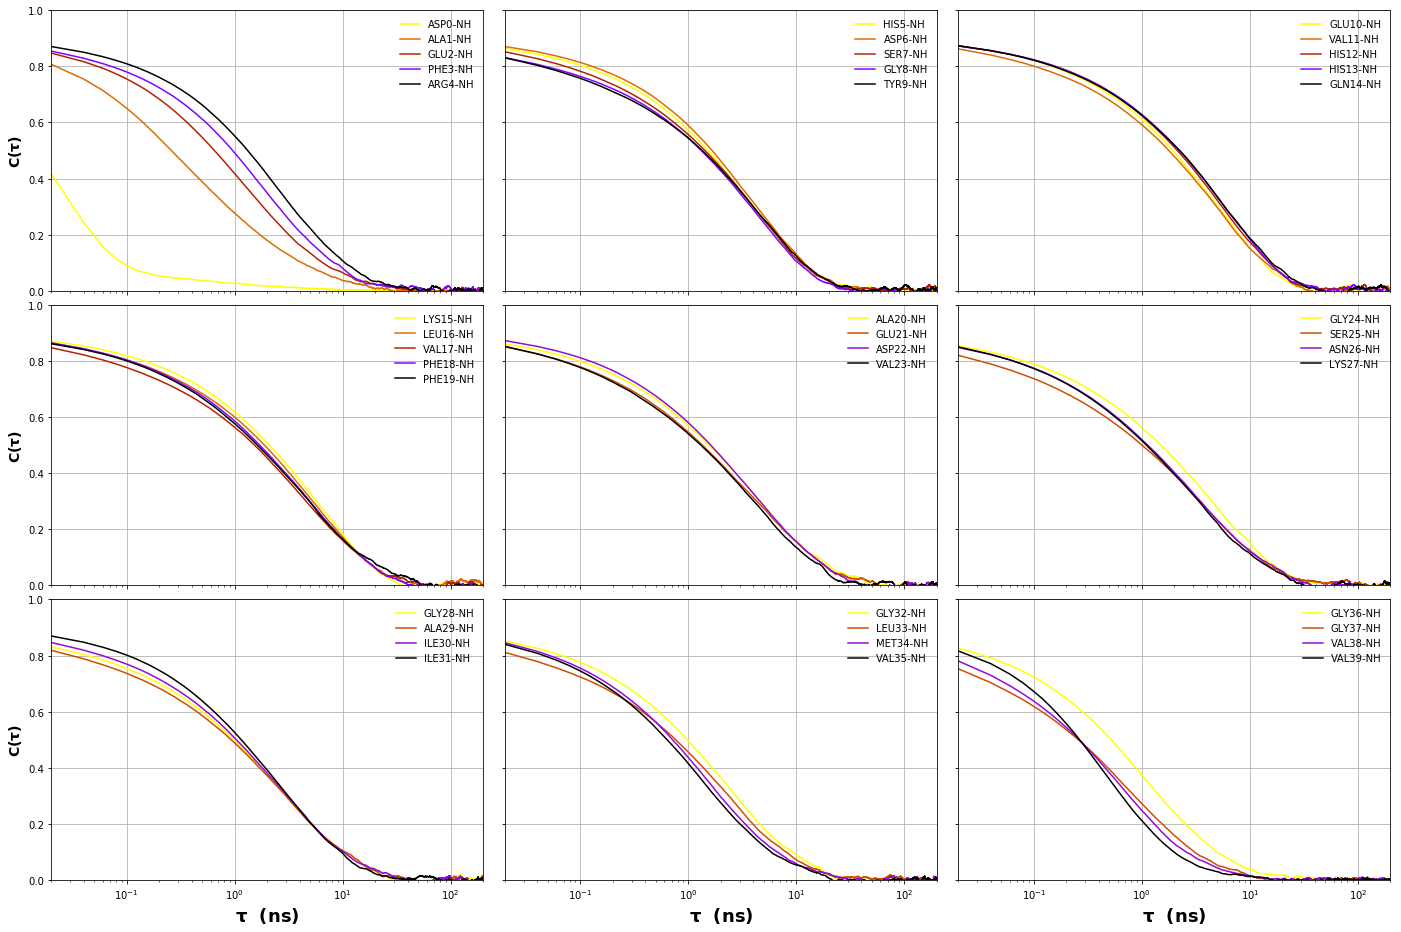

In [15]:
figCt, axesCt = plt.subplots(3,3,sharey=True, sharex=True, figsize=(24,16))
figCt.subplots_adjust(hspace=0.05,wspace=0.05)
NCt = [5,5,5,5,4,4,4,4,4]
start = 0
for n, ax in zip(NCt,axesCt.flatten()):
    end = start + n
    CtDF14.iloc[:,start:end].plot(grid=True, ax=ax, logx=True, xlim=(0.02,200), ylim=(0,1.0), cmap='gnuplot_r')
    start = end
    ax.legend(frameon=False,loc=1)
axesCt[0,0].set_ylabel(r'$\mathbf{C(\tau)}$',fontsize=14)
axesCt[1,0].set_ylabel(r'$\mathbf{C(\tau)}$',fontsize=14)
axesCt[2,0].set_ylabel(r'$\mathbf{C(\tau)}$',fontsize=14)
#axesCt[3,0].set_ylabel(r'$\mathbf{C(\tau)}$',fontsize=14)
#axesCt[4,0].set_ylabel(r'$\mathbf{C(\tau)}$',fontsize=14)
#axesCt[5,0].set_ylabel(r'$\mathbf{C(\tau)}$',fontsize=14)
for xl in axesCt[2,:]:
    xl.set_xlabel(r'$\mathbf{\tau \ \ (ns)}$', fontsize=18)


In [97]:
tau_mem=70.0
FitDF, covarMat_list = fitCorrF(CtDF14, dCtDF14, tau_mem, [6], fixfit=True)

Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials


/home/sdey8/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 expon

In [68]:
FitDF.tau_a_err.iloc[19]

0.08523391035954651

In [66]:
t_a=[]
t_b=[]
t_g=[]
t_a_er=[]
t_b_er=[]
t_g_er=[]
c_a=[]
c_a_er = []
c_b=[]
c_b_er = []
c_g=[]
c_g_er = []

n = 11

for tau_mem in range(15, 105, 5):
    FitDF, covarMat_list = fitCorrF(CtDF14, dCtDF14, tau_mem, [6], fixfit=True)  
    t_a.append(FitDF.tau_a.iloc[n])
    t_a_er.append(FitDF.tau_a_err.iloc[n])
    c_a.append(FitDF.C_a.iloc[n])
    c_a_er.append(FitDF.C_a_err.iloc[n])
    t_b.append(FitDF.tau_b.iloc[n])
    t_b_er.append(FitDF.tau_b_err.iloc[n])
    c_b.append(FitDF.C_b.iloc[n])
    c_b_er.append(FitDF.C_b_err.iloc[n])    
    t_g.append(FitDF.tau_g.iloc[n])
    t_g_er.append(FitDF.tau_g_err.iloc[n])
    c_g.append(FitDF.C_g.iloc[n])
    c_g_er.append(FitDF.C_g_err.iloc[n])

           
df = pd.DataFrame(list(zip(t_a, t_a_er, c_a, c_a_er, t_b, t_b_er, c_b, c_b_er, t_g, t_g_er, c_g, c_g_er,)), columns=['tau_a', 'tau_a_err', 'C_a', 'C_a_err', 'tau_b', 'tau_b_err', 'C_b', 'C_b_err', 'tau_g', 'tau_g_err', 'C_g', 'C_g_err',])   
df.index=np.arange(15, 105, 5)

Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials


/home/sdey8/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 exponentials
Performing a fixed fit for 3 expon

In [98]:
Jarr=[]
for i,fit in FitDF.iterrows():
    c = fit[['C_a','C_b','C_g','C_d']].values
    t = fit[['tau_a','tau_b','tau_g','tau_d']].values
    Jdict = {'0':0, '1H':0,'15N':0,'Sum':0,'Diff':0} 
    J0 = J_direct_transform(0, c, t)
    #print(J0)
    JH = J_direct_transform(Larmor1H, c, t)
    JN = J_direct_transform(Larmor15N, c, t)
    JSum = J_direct_transform(omSum,  c, t)
    JDiff = J_direct_transform(omDiff,  c, t)
    Jdict['1H'] = JH ; Jdict['15N'] = JN; Jdict['0'] = J0; 
    Jdict['Sum'] = JSum; Jdict['Diff'] = JDiff;
    Jarr.append(Jdict)

In [99]:
NMRRelaxDF = pd.DataFrame(np.zeros((len(Jarr),3)),index=range(1,len(Jarr)+1), columns=['T1','T2','NOE'])
for index in range(1,len(Jarr)+1):
    r1, r2, noe = calc_NMR_Relax(Jarr[index-1], FDD, FCSA, H_gyro, N_gyro)
    NMRRelaxDF.loc[index,'R1'] = r1; 
    NMRRelaxDF.loc[index,'R2'] = r2; 
    NMRRelaxDF.loc[index,'NOE'] = noe; 

NMRRelaxDF['Resname'] = FitDF['Resname'].values
NMRRelaxDF['RESNUM'] = NMRRelaxDF['Resname'].str.extract('([0-9]+)',expand=False).astype('int')+1  

In [100]:
FitRelaxDF = FitDF.merge(NMRRelaxDF, how='left', left_on='Resname',right_on='Resname').set_index(NMRRelaxDF.index)
FitRelaxName= "NMRFitRelax_{}_ab40_f_278K_600MHz_inf".format(int(tau_mem))
FitRelaxDF.to_csv('{}.csv'.format(FitRelaxName))

In [80]:
FTOPN = "PROD.noH20.ab40_f1_amber.parm7"
NHVecs = []

In [14]:
def ScaleNMRParams(FitDF, ScaleType=1, tau_0=12.0, tau_d=0.010):
    
    NMRRelax_Scl = FitDF.copy()
    
    if ScaleType == 1:
        print('Scaling all correlation times by : {}'.format(tau_0))
        
        NMRRelax_Scl['tau_a'] = NMRRelax_Scl['tau_a']/(1 + NMRRelax_Scl['tau_a']/tau_0)
        NMRRelax_Scl['tau_b'] = NMRRelax_Scl['tau_b']/(1 + NMRRelax_Scl['tau_b']/tau_0)
        NMRRelax_Scl['tau_g'] = NMRRelax_Scl['tau_g']/(1 + NMRRelax_Scl['tau_g']/tau_0)
    
        NMRRelax_Scl['AUC_a'] = NMRRelax_Scl['tau_a']*NMRRelax_Scl['C_a']
        NMRRelax_Scl['AUC_b'] = NMRRelax_Scl['tau_b']*NMRRelax_Scl['C_b']
        NMRRelax_Scl['AUC_g'] = NMRRelax_Scl['tau_g']*NMRRelax_Scl['C_g']
        NMRRelax_Scl['AUC_Total'] = NMRRelax_Scl[['AUC_a','AUC_b','AUC_g']].sum(axis=1)
    
    elif ScaleType == 2:
        print('Scaling NMR by adding very fast time constant, tau_d = {}'.format(tau_d))
        
        NMRRelax_Scl['C_d'] = 1 - NMRRelax_Scl[['C_a','C_b','C_g']].sum(axis=1)
        NMRRelax_Scl['tau_d'] = tau_d
        NMRRelax_Scl['AUC_d'] = NMRRelax_Scl['tau_d']*NMRRelax_Scl['C_d']
        NMRRelax_Scl['AUC_Total'] = NMRRelax_Scl[['AUC_a','AUC_b','AUC_g','AUC_d']].sum(axis=1)
    
    elif ScaleType == 3:
        print('Scaling only the longest correlation time, tau_a by : {}'.format(tau_0))
        
        NMRRelax_Scl['tau_a'] = NMRRelax_Scl['tau_a']/(1 + NMRRelax_Scl['tau_a']/tau_0)    
        NMRRelax_Scl['AUC_a'] = NMRRelax_Scl['tau_a']*NMRRelax_Scl['C_a']
        NMRRelax_Scl['AUC_Total'] = NMRRelax_Scl[['AUC_a','AUC_b','AUC_g','AUC_d']].sum(axis=1)
        
    elif ScaleType == 4:
        print('Scaling all correlation times by {} and adding very fast time constant at : {}'.format(tau_0, tau_d))
        
        NMRRelax_Scl['C_d'] = 1 - NMRRelax_Scl[['C_a','C_b','C_g']].sum(axis=1)
        NMRRelax_Scl['tau_d'] = tau_d
        NMRRelax_Scl['AUC_d'] = NMRRelax_Scl['tau_d']*NMRRelax_Scl['C_d']
        
        NMRRelax_Scl['tau_a'] = NMRRelax_Scl['tau_a']/(1 + NMRRelax_Scl['tau_a']/tau_0)
        NMRRelax_Scl['tau_b'] = NMRRelax_Scl['tau_b']/(1 + NMRRelax_Scl['tau_b']/tau_0)
        NMRRelax_Scl['tau_g'] = NMRRelax_Scl['tau_g']/(1 + NMRRelax_Scl['tau_g']/tau_0)
    
        NMRRelax_Scl['AUC_a'] = NMRRelax_Scl['tau_a']*NMRRelax_Scl['C_a']
        NMRRelax_Scl['AUC_b'] = NMRRelax_Scl['tau_b']*NMRRelax_Scl['C_b']
        NMRRelax_Scl['AUC_g'] = NMRRelax_Scl['tau_g']*NMRRelax_Scl['C_g']
        NMRRelax_Scl['AUC_Total'] = NMRRelax_Scl[['AUC_a','AUC_b','AUC_g','AUC_d']].sum(axis=1)
        
    elif ScaleType == 5:
        print('Scaling only the longest correlation time, tau_a by : {}'.format(tau_0))
        
        NMRRelax_Scl['tau_a'] = NMRRelax_Scl['tau_a']/(1 + NMRRelax_Scl['tau_a']/tau_0)    
        NMRRelax_Scl['AUC_a'] = NMRRelax_Scl['tau_a']*NMRRelax_Scl['C_a']
        
        NMRRelax_Scl['C_d'] = 1 - NMRRelax_Scl[['C_a','C_b','C_g']].sum(axis=1)
        NMRRelax_Scl['tau_d'] = tau_d
        NMRRelax_Scl['AUC_d'] = NMRRelax_Scl['tau_d']*NMRRelax_Scl['C_d']
        NMRRelax_Scl['AUC_Total'] = NMRRelax_Scl[['AUC_a','AUC_b','AUC_g','AUC_d']].sum(axis=1)
        
    elif ScaleType == 6:
        print('Scaling all correlation times by predefined scaling parameters')
       
        NMRRelax_Scl['tau_a'] = NMRRelax_Scl['tau_a']/(1.52603 + NMRRelax_Scl['tau_a']*0.086184)
        NMRRelax_Scl['tau_b'] = NMRRelax_Scl['tau_b']/(1.52603 + NMRRelax_Scl['tau_b']*0.086184)
        NMRRelax_Scl['tau_g'] = NMRRelax_Scl['tau_g']/(1.52603 + NMRRelax_Scl['tau_g']*0.086184)
   
        NMRRelax_Scl['AUC_a'] = NMRRelax_Scl['tau_a']*NMRRelax_Scl['C_a']
        NMRRelax_Scl['AUC_b'] = NMRRelax_Scl['tau_b']*NMRRelax_Scl['C_b']
        NMRRelax_Scl['AUC_g'] = NMRRelax_Scl['tau_g']*NMRRelax_Scl['C_g']
        NMRRelax_Scl['AUC_Total'] = NMRRelax_Scl[['AUC_a','AUC_b','AUC_g']].sum(axis=1)
    
    for i,fit in NMRRelax_Scl.iterrows():
        c = fit[['C_a','C_b','C_g','C_d']].values
        t = fit[['tau_a','tau_b','tau_g','tau_d']].values
        Jdict = {'0':0, '1H':0,'15N':0,'Sum':0,'Diff':0} 
        J0 = J_direct_transform(0, c, t)
        JH = J_direct_transform(Larmor1H, c, t)
        JN = J_direct_transform(Larmor15N, c, t)
        JSum = J_direct_transform(omSum,  c, t)
        JDiff = J_direct_transform(omDiff,  c, t)
        Jdict['1H'] = JH ; Jdict['15N'] = JN; Jdict['0'] = J0; 
        Jdict['Sum'] = JSum; Jdict['Diff'] = JDiff;
        r1, r2, noe = calc_NMR_Relax(Jdict, FDD, FCSA, H_gyro, N_gyro)
        NMRRelax_Scl.loc[i, 'R1'] = r1 
        NMRRelax_Scl.loc[i, 'R2'] = r2
        NMRRelax_Scl.loc[i, 'NOE'] = noe
        NMRRelax_Scl.loc[i, 'R1_SE'] = np.square(NMRRelax_Scl.loc[i, 'R1'] - EXPNOEdf.loc[i, 'R1-Exp'])
        NMRRelax_Scl.loc[i, 'R2_SE'] = np.square(NMRRelax_Scl.loc[i, 'R2'] - EXPNOEdf.loc[i, 'R2-Exp'])
        NMRRelax_Scl.loc[i, 'NOE_SE'] = np.square(NMRRelax_Scl.loc[i, 'NOE'] - EXPNOEdf.loc[i, 'NOE-Exp'])

    return NMRRelax_Scl

In [25]:
FitDF1 = pd.read_csv('NMRFitRelax_15_ab40_f_278K_600MHz_15_inf_corrected.csv', index_col=0)

In [16]:
EXPNOEdf = pd.read_csv('NMRFitRelax_final_ab40_f_278K_600MHz.csv', index_col=0)

In [17]:
NMRRelaxDF14_Scl1 = ScaleNMRParams(FitDF1, ScaleType=6)

Scaling all correlation times by predefined scaling parameters


In [18]:
Jarr=[]
for i,fit in NMRRelaxDF14_Scl1.iterrows():
    c = fit[['C_a','C_b','C_g','C_d']].values
    t = fit[['tau_a','tau_b','tau_g','tau_d']].values
    Jdict = {'0':0, '1H':0,'15N':0,'Sum':0,'Diff':0} 
    J0 = J_direct_transform(0, c, t)
    JH = J_direct_transform(Larmor1H, c, t)
    JN = J_direct_transform(Larmor15N, c, t)
    JSum = J_direct_transform(omSum,  c, t)
    JDiff = J_direct_transform(omDiff,  c, t)
    Jdict['1H'] = JH ; Jdict['15N'] = JN; Jdict['0'] = J0; 
    Jdict['Sum'] = JSum; Jdict['Diff'] = JDiff;
    Jarr.append(Jdict)

In [19]:
NMRRelaxDF = pd.DataFrame(np.zeros((len(Jarr),3)),index=range(1,len(Jarr)+1), columns=['R1','R2','NOE'])
for index in range(1,len(Jarr)+1):
    r1, r2, noe = calc_NMR_Relax(Jarr[index-1], FDD, FCSA, H_gyro, N_gyro)
    NMRRelaxDF.loc[index,'R1'] = r1; 
    NMRRelaxDF.loc[index,'R2'] = r2; 
    NMRRelaxDF.loc[index,'NOE'] = noe; 

NMRRelaxDF['Resname'] = FitDF1['Resname'].values
NMRRelaxDF['RESNUM'] = NMRRelaxDF['Resname'].str.extract('([0-9]+)',expand=False).astype('int')+1 

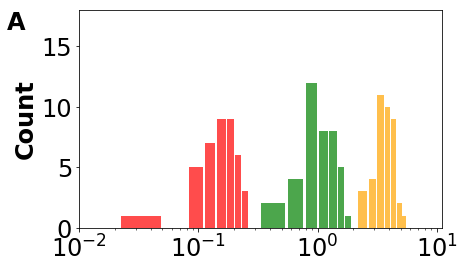

In [64]:
# An "interface" to matplotlib.axes.Axes.hist() method
fig_f3 = plt.figure(131512, figsize=(6.5,4))
axf3 = plt.subplot(111)

a = NMRRelaxDF14_Scl1["tau_a"]
b = NMRRelaxDF14_Scl1["tau_b"]
g = NMRRelaxDF14_Scl1["tau_g"]

plt.hist(x=a, bins='auto', color='orange', alpha=0.7, rwidth=0.85)
plt.hist(x=b, bins='auto', color='green', alpha=0.7, rwidth=0.85)
plt.hist(x=g, bins='auto', color='red', alpha=0.7, rwidth=0.85)

plt.xscale('log')
plt.xlim(0.01,11)
plt.ylim(0,18)

plt.tick_params(labelsize=24)
#plt.legend(frameon=False,loc=0,prop={'size':14,'weight':'bold'}, ncol=4)
#plt.grid(axis='y', alpha=0.75)
#plt.xlabel('Time Constant (ns)', weight='bold', fontsize=15 )
plt.ylabel('Count',weight='bold', fontsize=24)
#plt.title('Time Constants (ns)')
plt.text(0.0025,18,'A', weight='bold',fontsize=24, ha='left',va='top')
#maxfreq = n.max()
#Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('ab40_timeConstant_Hist_15_inf.png', bbox_inches='tight',dpi=600)

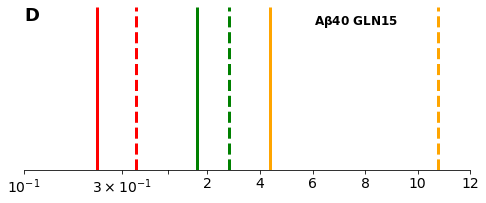

In [26]:
fig_f3 = plt.figure(131512, figsize=(8,3))
axf3 = plt.subplot(111)

a = FitDF1["tau_a"][15]
b = FitDF1["tau_b"][15]
g = FitDF1["tau_g"][15]

a1 = NMRRelaxDF14_Scl1["tau_a"][15]
b1 = NMRRelaxDF14_Scl1["tau_b"][15]
g1 = NMRRelaxDF14_Scl1["tau_g"][15]

axf3.vlines(x=a, ymin = 0, ymax = 0.5, linewidth=3, color ="orange", linestyle ="--")
axf3.vlines(x=b, ymin = 0, ymax = 0.5, linewidth=3, color ="green", linestyle ="--")

axf3.vlines(x=a1, ymin = 0, ymax = 0.5, linewidth=3, color ="orange", linestyle ="-")
axf3.vlines(x=b1, ymin = 0, ymax = 0.5, linewidth=3, color ="green", linestyle ="-")

axf3.set_xlim(0.5,12)
axf3.set_ylim(0,0.5)
axf3.set_xscale('linear')

axf3.axes.yaxis.set_visible(False)
plt.tick_params(labelsize=14)



divider = make_axes_locatable(axf3)

axLin = divider.append_axes("left", size=2.0, pad=0, sharey=axf3)
axLin.set_xscale('log')
axLin.set_xlim((0.1, 0.5))

axLin.vlines(x=g, ymin = 0, ymax = 0.5, linewidth=3, color ="red", linestyle ="--")
axLin.vlines(x=g1, ymin = 0, ymax = 0.5, linewidth=3, color ="red", linestyle ="-")


#axLin.bar(x=g1, height = 1, color='red', alpha=0.7, width=0.005)


axLin.set_xticks([0.1, 0.3, 0.5])
plt.tick_params(labelsize=14)
axLin.axes.yaxis.set_visible(False)
axLin.minorticks_off()

list(axLin.spines.values())[1].set_visible(False)
list(axLin.spines.values())[3].set_visible(False)
list(axLin.spines.values())[0].set_visible(False)

list(axf3.spines.values())[1].set_visible(False)
list(axf3.spines.values())[3].set_visible(False)
list(axf3.spines.values())[0].set_visible(False)

plt.text(0.1,0.5,'D', weight='bold',fontsize=18, ha='left',va='top')
plt.text(2.55,0.48,r'$\mathbf{A\beta 40 \ GLN15}$',fontsize=12, ha='left',va='top')

#plt.xlabel('Time Constant (ns)', weight='bold', fontsize=15 )

plt.savefig('ab40_timeConstant_Hist_GLN15.png', bbox_inches='tight',dpi=600)

In [35]:
FitRelaxName= "ab40_f_278_2500ns_scaled_langevin"
NMRRelaxDF.to_csv('{}.csv'.format(FitRelaxName))

# PLOT THE RELAXATION DATA

In [ ]:
def _plot_NMRRelax(fitdf, nmr_expdf, nres, r1r2_lim, fsize=(8,10)):
    
    fignmr_err, axnmr_err = plt.subplots(2, 1, sharex=True,figsize=fsize)
    fignmr_err.subplots_adjust(hspace=0.025)
    RMSE_R1R2 = np.sqrt(fitdf.iloc[1:-1][['R1_SE','R2_SE','NOE_SE']].mean())
    
    ##R1 Plots 
    axR1 = axnmr_err[0]
    nmr_expdf[['RESID','R1']].plot(x='RESID', y='R1',ax=axR1, color='k',
                                    label=r'$\mathit{R}_\mathbf{1}$_Exp',
                                    linestyle='-', linewidth=2, marker='d')
        
    fitdf[['RESNUM','R1']].plot(x='RESNUM',y='R1', ax=axR1, color='teal', 
                                 label=r'$\mathit{{R}}_\mathbf{{1}}$-RMSE:{:.2}'.format(RMSE_R1R2['R1_SE']),
                                 linewidth=2, linestyle='-', marker='o')

    ## R2 Plots
    nmr_expdf[['RESID','R2']].plot(x='RESID', y='R2',ax=axR1, color='k',
                                    label=r'$\mathit{{R}}_\mathbf{{2}}$_Exp',
                                    linestyle='--', linewidth=2, marker='d')
        
    fitdf[['RESNUM','R2']].plot(x='RESNUM',y='R2', ax=axR1, color='#fb7d07',  
                                 label=r'$\mathit{{R}}_\mathbf{{2}}$-RMSE:{:.2}'.format(RMSE_R1R2['R2_SE']),
                                 linewidth=2, linestyle='--', marker='o')
    

    #axR2.text(1, 6.40, 'b', weight='bold',fontsize=18, ha='left',va='top')
    #axR1.set_ylabel(r'$\mathit{R}_\mathbf{2} \ \ (s^{-1})$', weight='bold', fontsize=15)
    #axR1.legend(frameon=False, loc='3', prop={'size':14,'weight':'bold'})
    axR1.set_ylim(r1r2_lim[0], r1r2_lim[1])
    axR1.set_ylabel(r'$\mathit{R}_\mathbf{1,2} \ \ (s^{-1})$', weight='bold', fontsize=15)
    axR1.legend(frameon=False, ncol=2, mode='expand', loc='upper left', prop={'size':14,'weight':'bold'})
    axR1.tick_params(labelsize=14)
    
    ## NOE Plots
    axNOE = axnmr_err[1]
    nmr_expdf[['RESID','NOE']].plot(x='RESID', y='NOE', ax=axNOE, color='k',
                                             label='NOE_Exp',
                                    linestyle='-',ylim=(0.0,1.0), linewidth=2, marker='d')

        
    fitdf[['RESNUM','NOE']].plot(x='RESNUM',y='NOE', ax=axNOE, color='green',
                                  label='NOE-RMSE:{:.1}'.format(RMSE_R1R2['NOE_SE']),
                                  linewidth=2, linestyle='-' , marker='o')


    #axNOE.text(1,0.95,'c', weight='bold',fontsize=18, ha='left',va='top')
    axNOE.set_ylabel(r'$\mathbf{^{1}H-^{15}N}$ Het. NOE', weight='bold', fontsize=15)
    axNOE.set_xlabel('Residue Number', weight='bold', fontsize=15)
    axNOE.set_xlim(0, nres+1)
    axNOE.legend(frameon=False, prop={'size':14,'weight':'bold'})
    axNOE.set_xticks(np.arange(0, nres, 10))
    axNOE.set_xticks(np.arange(0, nres, 5), minor=True)
    axNOE.set_xticklabels(np.arange(0, nres, 10))
    axNOE.tick_params(labelsize=14)
    
    return fignmr_err

In [16]:
DSSP = pd.read_csv('../rg_dssp/ab40_f_278_dssp.csv', index_col=0)

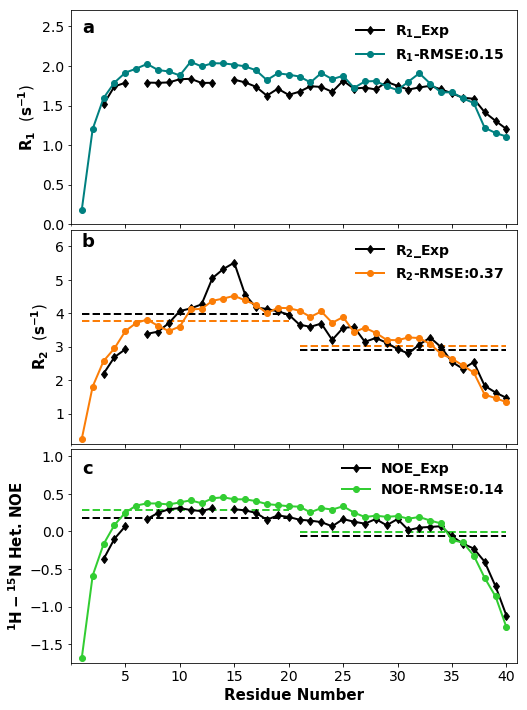

In [12]:
figNMR_Err, axNMR_Err = plt.subplots(5, 1, sharex=True, figsize=(8,12))
figNMR_Err.subplots_adjust(hspace=0.025)
RMSE_R1R2 = np.sqrt(NMRRelaxDF14_Scl1.iloc[1:-1][['R1_SE','R2_SE','NOE_SE']].mean())

##R1 Plots 
axR1 = axNMR_Err[0]

NMRRelaxDF14_Scl1[['RESNUM','R1-Exp']].plot(x='RESNUM', y='R1-Exp',ax=axR1, color='k',
                                                label=r'$\mathbf{R}_\mathbf{1}$_Exp',
                                                linestyle='-', linewidth=2, marker='d')

NMRRelaxDF[['RESNUM','R1']].plot(x='RESNUM',y='R1', ax=axR1, color='teal', 
                                 label=r'$\mathbf{{R}}_\mathbf{{1}}$-RMSE:{:.2}'.format(RMSE_R1R2['R1_SE']),
                                 linewidth=2, linestyle='-', marker='o')

axR1.set_ylim(0, 2.7)
axR1.text(1,2.60,'a', weight='bold',fontsize=18, ha='left',va='top')
axR1.set_ylabel(r'$\mathbf{R}_\mathbf{1} \ \ (\mathbf{s}^\mathbf{-1})$', weight='bold', fontsize=15)
axR1.legend(frameon=False, loc='best', prop={'size':14,'weight':'bold'})
axR1.tick_params(labelsize=14)


## R2 Plots
axR2 = axNMR_Err[1]

NMRRelaxDF14_Scl1[['RESNUM','R2-Exp']].plot(x='RESNUM', y='R2-Exp',ax=axR2, color='k',
                                                label=r'$\mathbf{{R}}_\mathbf{{2}}$_Exp',
                                                linestyle='-', linewidth=2, marker='d')

NMRRelaxDF[['RESNUM','R2']].plot(x='RESNUM',y='R2', ax=axR2, color='#fb7d07',  
                                 label=r'$\mathbf{{R}}_\mathbf{{2}}$-RMSE:{:.2}'.format(RMSE_R1R2['R2_SE']),
                                 linewidth=2, linestyle='-', marker='o')

axR2.text(1,6.40,'b', weight='bold',fontsize=18, ha='left',va='top')
axR2.set_ylabel(r'$\mathbf{R}_\mathbf{2} \ \ (\mathbf{s}^\mathbf{-1})$', weight='bold', fontsize=15)
axR2.legend(frameon=False, loc='best', prop={'size':14,'weight':'bold'})
axR2.tick_params(labelsize=14)
axR2.set_ylim(0.1,6.5)

axR2.hlines(y=NMRRelaxDF['R2'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="#fb7d07", linestyle ="--")
axR2.hlines(y=NMRRelaxDF['R2'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="#fb7d07", linestyle ="--")

axR2.hlines(y=NMRRelaxDF14_Scl1['R2-Exp'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="k", linestyle ="--")
axR2.hlines(y=NMRRelaxDF14_Scl1['R2-Exp'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="k", linestyle ="--")


## NOE Plots
axNOE = axNMR_Err[2]

NMRRelaxDF14_Scl1[['RESNUM','NOE-Exp']].plot(x='RESNUM', y='NOE-Exp', ax=axNOE, color='k',
                                                 label='NOE_Exp',
                                                  linestyle='-',ylim=(0.0,1.0), linewidth=2, marker='d')
NMRRelaxDF[['RESNUM','NOE']].plot(x='RESNUM',y='NOE', ax=axNOE, color='limegreen',
                                  label='NOE-RMSE:{:.2}'.format(RMSE_R1R2['NOE_SE']),
                                  linewidth=2, linestyle='-' , marker='o')

axNOE.text(1,0.95,'c', weight='bold',fontsize=18, ha='left',va='top')
axNOE.set_ylabel(r'$\mathbf{^{1}H-^{15}N}$ Het. NOE', weight='bold', fontsize=15)
axNOE.set_xlabel('Residue Number', weight='bold', fontsize=15)
axNOE.set_ylim(-1.75,1.1)
axNOE.set_xlim(0,41)

axNOE.hlines(y=NMRRelaxDF['NOE'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="limegreen", linestyle ="--")
axNOE.hlines(y=NMRRelaxDF['NOE'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="limegreen", linestyle ="--")

axNOE.hlines(y=NMRRelaxDF14_Scl1['NOE-Exp'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="k", linestyle ="--")
axNOE.hlines(y=NMRRelaxDF14_Scl1['NOE-Exp'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="k", linestyle ="--")


axNOE.legend(frameon=False,loc=1,prop={'size':14,'weight':'bold'})
axNOE.set_xticks(np.arange(5,41,5))
axNOE.set_xticklabels(np.arange(5,41,5))
axNOE.tick_params(labelsize=14)

figNMR_Err.savefig('NMRRelax_ab40_f_278.png',
              bbox_inches='tight',dpi=600)

"\nNMRRelaxDF14_Scl1[['RESNUM','tau_a','tau_a_err']].plot(x='RESNUM', y='tau_a', yerr='tau_a_err', c='blue',\n                                                    ax=axf3[1], label=r'$\\mathbf{\tau_{1}}$',\n                                                    linewidth=2, marker='o',linestyle='-')\nNMRRelaxDF14_Scl1[['RESNUM','tau_b','tau_b_err']].plot(x='RESNUM', y='tau_b', yerr='tau_b_err', c='green',\n                                                    ax=axf3[1], logy=True, label=r'$\\mathbf{\tau_{2}}$',\n                                                    linewidth=2, marker='o',linestyle='-')\nNMRRelaxDF14_Scl1[['RESNUM','tau_g','tau_g_err']].plot(x='RESNUM', y='tau_g', yerr='tau_g_err', c='red',\n                                                    ax=axf3[1], logy=True, label=r'$\\mathbf{\tau_{3}}$',\n                                                    linewidth=2, marker='o',linestyle='-')    \n\n    \naxf3[1].tick_params(labelsize=15, which='both')\naxf3[1].set_yticks(np.linspac

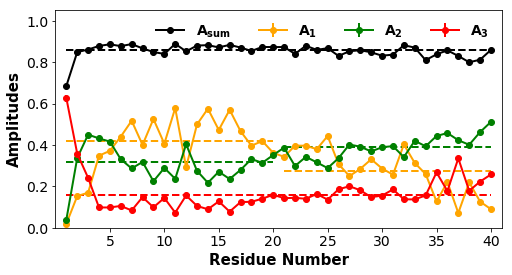

In [150]:
fig_f3 = plt.figure(131512, figsize=(8,4))
axf3 = plt.subplot(111)

#fig_f3, axf3 = plt.subplots(111, figsize=(8,8))
#fig_f3.subplots_adjust(hspace=0.05)
#ylim_t1=(1,8)
    
## Plot the Amplitudes to S1
NMRRelaxDF14_Scl1[['RESNUM','C_a','C_a_err']].plot(x='RESNUM', y='C_a', yerr='C_a_err', c='orange',
                                                ax=axf3, label=r'$\mathbf{A_1}$',
                                                linewidth=2, marker='o', linestyle='-')

NMRRelaxDF14_Scl1[['RESNUM','C_b','C_b_err']].plot(x='RESNUM', y='C_b', yerr='C_b_err', c='green',
                                                ax=axf3,  label=r'$\mathbf{A_2}$',
                                                linewidth=2, marker='o', linestyle='-')

NMRRelaxDF14_Scl1[['RESNUM','C_g','C_g_err']].plot(x='RESNUM', y='C_g', yerr='C_g_err', c='red',
                                                ax=axf3,  label=r'$\mathbf{A_3}$',
                                                linewidth=2, marker='o', linestyle='-')

NMRRelaxDF14_Scl1[['RESNUM','A_Total']].plot(x='RESNUM', y='A_Total', c='black',
                                                ax=axf3,  label=r'$\mathbf{A_{sum}}$',
                                                linewidth=2, marker='o', linestyle='-')

axf3.hlines(y=NMRRelaxDF14_Scl1['C_a'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="orange", linestyle ="--")
axf3.hlines(y=NMRRelaxDF14_Scl1['C_a'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="orange", linestyle ="--")

axf3.hlines(y=NMRRelaxDF14_Scl1['C_b'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="g", linestyle ="--")
axf3.hlines(y=NMRRelaxDF14_Scl1['C_b'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="g", linestyle ="--")

axf3.hlines(y=NMRRelaxDF14_Scl1['C_g'][1:40].mean(), xmin = 1, xmax = 40, linewidth=2, color ="r", linestyle ="--")
#axf3.hlines(y=NMRRelaxDF14_Scl1['C_g'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="r", linestyle ="--")

axf3.hlines(y=NMRRelaxDF14_Scl1['A_Total'][1:40].mean(), xmin = 1, xmax = 40, linewidth=2, color ="k", linestyle ="--")
#axf3.hlines(y=NMRRelaxDF14_Scl1['A_Total'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="k", linestyle ="--")


axf3.set_ylim(0, 1.05)
axf3.set_ylabel(r'Amplitudes', fontsize=15, weight='bold')

axf3.set_xlabel('Residue Number', weight='bold', fontsize=15)
axf3.set_xlim(0,41)
axf3.legend(frameon=False,loc=0,prop={'size':14,'weight':'bold'}, ncol=4)
axf3.set_xticks(np.arange(5,41,5))
axf3.set_xticklabels(np.arange(5,41,5))

axf3.tick_params(labelsize=14)

fig_f3.savefig('amp_ab40_f_278.png',
              bbox_inches='tight',dpi=300)

'''
NMRRelaxDF14_Scl1[['RESNUM','tau_a','tau_a_err']].plot(x='RESNUM', y='tau_a', yerr='tau_a_err', c='blue',
                                                    ax=axf3[1], label=r'$\mathbf{\tau_{1}}$',
                                                    linewidth=2, marker='o',linestyle='-')
NMRRelaxDF14_Scl1[['RESNUM','tau_b','tau_b_err']].plot(x='RESNUM', y='tau_b', yerr='tau_b_err', c='green',
                                                    ax=axf3[1], logy=True, label=r'$\mathbf{\tau_{2}}$',
                                                    linewidth=2, marker='o',linestyle='-')
NMRRelaxDF14_Scl1[['RESNUM','tau_g','tau_g_err']].plot(x='RESNUM', y='tau_g', yerr='tau_g_err', c='red',
                                                    ax=axf3[1], logy=True, label=r'$\mathbf{\tau_{3}}$',
                                                    linewidth=2, marker='o',linestyle='-')    

    
axf3[1].tick_params(labelsize=15, which='both')
axf3[1].set_yticks(np.linspace(ylim_t1[0], ylim_t1[1], ylim_t1[1] - ylim_t1[0]+1)[1:-1], minor=True)
axf3[1].set_yticklabels(np.linspace(ylim_t1[0], ylim_t1[1], ylim_t1[1] - ylim_t1[0]+1)[1:-1], minor=True)
axf3[1].yaxis.set_minor_formatter(mticker.ScalarFormatter())

axf3[1].yaxis.set_major_formatter(mticker.ScalarFormatter())

axf3[1].set_ylim(ylim_t1[0], ylim_t1[1])
axf3[1].set_ylabel(r'$\mathbf{\tau \ \ (ns)}$', fontsize=15, weight='bold')
axf3[1].legend(loc=1, frameon=False)
    

for axfit in axf3:
    axfit.set_xlim(0, 41)
    axfit.set_xticks(np.arange(0, 41, 5))
    axfit.set_xticks(np.arange(0, 41, 5), minor=True)
    axfit.tick_params(labelsize=15)
        
axf3[0].set_xticklabels([])
axf3[1].set_xticklabels(np.arange(0,41,5))
axf3[1].set_xlim(-1, 41)

fig_f3.canfig = plt.figure(131512, figsize=(9,7))
ax = plt.subplot(111)vas.draw()

f3s1_ylbl_pos = axf3[0].yaxis.label.get_position()
f3s2_ylbl_pos = axf3[1].yaxis.label.get_position()

print(f3s1_ylbl_pos, f3s2_ylbl_pos)
'''
#axf3[1].set_ylabel(r'$\mathbf{\tau \ \ (ns)}$', labelpad = (f3s2_ylbl_pos[0] - f3s2_ylbl_pos[0] + 4.0),
#                       fontsize=15, weight='bold')
#axf3.set_ylabel(r'$\mathbf{Amplitudes}$', labelpad = (f3s1_ylbl_pos[0] - f3s1_ylbl_pos[0] + 4.0),
#                       fontsize=15, weight='bold')

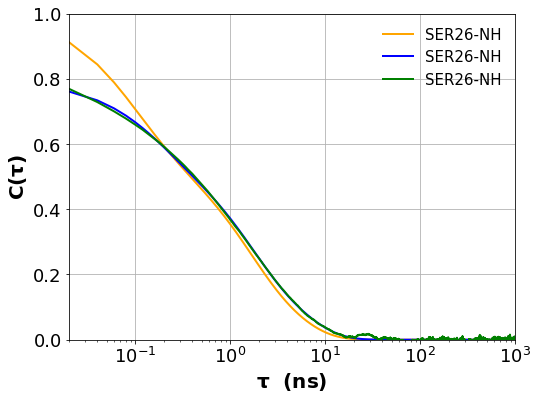

In [37]:
figProbDecays = plt.figure(5,figsize=(8,6))
axPD = figProbDecays.add_subplot(111)

RESExamples = ['SER26-NH']#, 'ARG46-NH','ALA61-NH', 'GLN78-NH']
AUCTExamples = NMRRelaxDF14_SclB[['Resname','AUC_Total']].set_index('Resname').loc[RESExamples].sort_values('AUC_Total')
ResESorted = AUCTExamples.index.values
ind_re = [np.where(NMRRelaxDF14_SclB['Resname']==RE)[0][0] for RE in RESExamples]
x = CtDF14.index.values
Example_Model_DF = pd.DataFrame(index=x, columns=RESExamples) 
for RE in RESExamples:
    ind_re = np.where(NMRRelaxDF14_SclB['Resname']==RE)[0][0]
    Example_Model_DF.loc[:,RE]  = func_exp_decay8(x, *NMRRelaxDF14_SclB.iloc[ind_re][['C_a','tau_a','C_b','tau_b','C_g','tau_g','C_d','tau_d']].values)

AUCTExamples2 = FitDF[['Resname','AUC_Total']].set_index('Resname').loc[RESExamples].sort_values('AUC_Total')
ResESorted2 = AUCTExamples2.index.values
ind_re2 = [np.where(FitDF['Resname']==RE)[0][0] for RE in RESExamples]
x2 = CtDF14.index.values
Example_Model_DF2 = pd.DataFrame(index=x2, columns=RESExamples) 
for RE in RESExamples:
    ind_re = np.where(FitDF['Resname']==RE)[0][0]
    Example_Model_DF2.loc[:,RE]  = func_exp_decay6(x, *FitDF.iloc[ind_re][['C_a','tau_a','C_b','tau_b','C_g','tau_g']].values)


Example_Model_DF[ResESorted].plot.line(grid=True,xlim=(0.02, 1000), color=['orange'],logx=True, ylim=(0.0, 1.0), ax=axPD, linewidth=2,label='Scaling w tf')
#Example_Model_DF1[ResESorted1].plot.line(grid=True, xlim=(0.02, 1000), color=['red'],logx=True, ylim=(0.0, 1.0), ax=axPD, linewidth=2,label='only tf')
Example_Model_DF2[ResESorted2].plot.line(grid=True, xlim=(0.02, 1000), color=['blue'],logx=True, ylim=(0.0, 1.0), ax=axPD, linewidth=2,label='Fit')

CtDF14[ResESorted].plot(grid=True, xlim=(0.02,1000), color=['green'],logx=True, ylim=(0.0,1.0), ax=axPD, linewidth=2,label='Sim')

axPD.set_ylabel(r'$\mathbf{C(\tau)}$',fontsize=20)
axPD.set_xlabel(r'$\mathbf{\tau \ \ (ns)}$', fontsize=20)

RgHandles, RgLabels = axPD.get_legend_handles_labels()
axPD.legend(RgHandles, RgLabels, frameon=False,prop={'size':15})
legend_labels1 = ['{}-Sim'.format(RD.split('-')[0]) for RD in ResESorted]
#legend_labels2 = ['{}'.format(RD.split('-')[0]) for RD in ResESorted]
#axPD.legend(np.hstack([ExResNew]), frameon=False, prop={'size':20,'weight':'bold'})
#axPD.set_title('Example Shortest and Longest Effective Correlations',weight='bold',size=14)
axPD.tick_params(labelsize=18)

Scaling NMR by adding very fast time constant, tau_d = 0.006


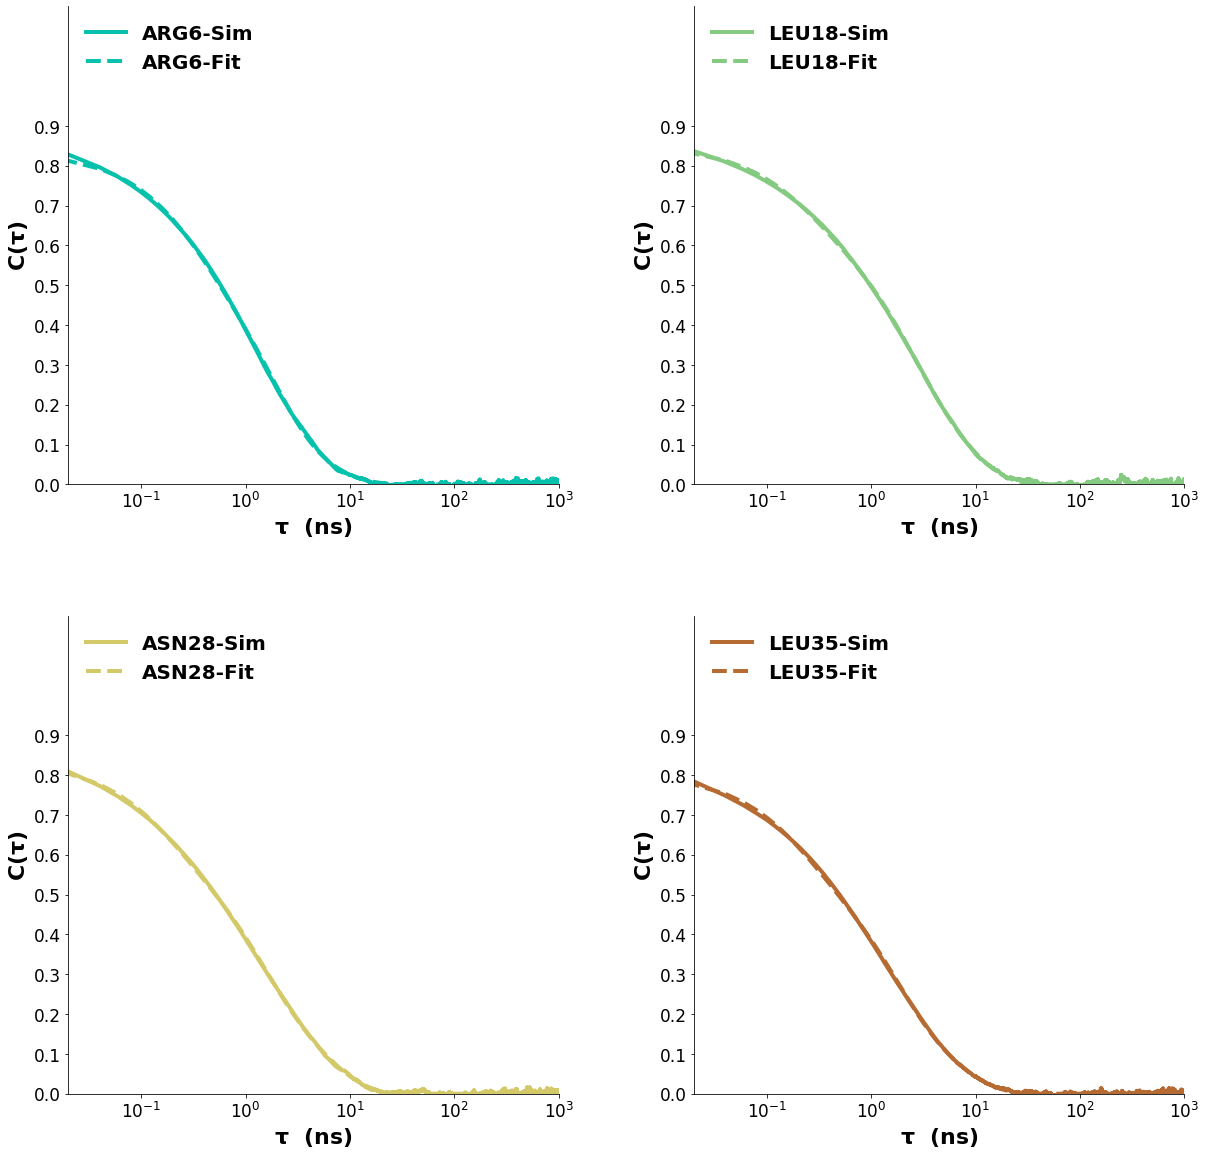

In [60]:
tau_d = 0.006
NMRRelax_Scl2= ScaleNMRParams(FitDF, ScaleType=2, tau_d = tau_d)

figExDecays, axExDecays = plt.subplots(2,2,figsize=(20,20), sharex=False, sharey=False, num=30691)
figExDecays.subplots_adjust(hspace=0.275, wspace=0.275)

#fign_long = 'ExampleCorrelations_tauM{}ns_SimvsFit_threshNone_36us_FixExp3_NBInf_TestingTfRed_noSplines'.format(int(tau_mem), 'None')
RESExamples = ['ARG5-NH', 'LEU17-NH','ASN27-NH', 'LEU34-NH']# , 'ARG55-NH']

ind_re = [np.where(NMRRelax_Scl2['Resname']==RE)[0][0] for RE in RESExamples]
x = CtDF14.index.values
x_wfast = np.hstack([np.arange(0.001,0.020,0.001),x])
Example_Model_DF = pd.DataFrame(index=x_wfast, columns=RESExamples)
Example_Model_DF_Opt = pd.DataFrame(index=x_wfast, columns=RESExamples)
Example_Model_DF_Add = pd.DataFrame(index=x_wfast, columns=RESExamples)
for RE in RESExamples:
    ind_re = np.where(FitDF['Resname']==RE)[0][0]
    Example_Model_DF.loc[:,RE]  = func_exp_decay6(x_wfast, *FitDF.iloc[ind_re][['C_a','tau_a','C_b','tau_b','C_g','tau_g']].values)
    Example_Model_DF_Opt.loc[:,RE]  = func_exp_decay8(x_wfast, *NMRRelax_Scl2.iloc[ind_re][['C_a','tau_a','C_b','tau_b','C_g','tau_g','C_d','tau_d']].values)
    ExpFit = func_exp_decay2(x_wfast, *NMRRelax_Scl2.iloc[ind_re][['C_d','tau_d']].values)
    Example_Model_DF_Add.loc[:,RE]  = Example_Model_DF.loc[:,RE] + ExpFit

clist = ['#06c2ac','#5a9e58', '#797419', '#85440a', '#7b0323']
clist2 = ['#06c2ac', '#84ca80', '#d3c968', '#b56b31', '#7b0323']

for RES, AX, cl in zip(RESExamples, axExDecays.flatten(), clist2[:-1]):
    
    CtDF14[RES].plot.line(grid=False, xlim=(0.02, 1000), logx=True, color=cl,
                             ylim=(0.0, 1.0), ax=AX, linestyle='-', linewidth=4)
    Example_Model_DF[RES].plot.line(grid=False, xlim=(0.02, 1000), color=cl,
                                       logx=True, ylim=(0.0, 1.2), ax=AX, linestyle='--', linewidth=4)

    if RES == 'GLY41-NH':
        AX.set_ylim((0,0.8))
        AX.set_yticks(np.arange(0.0,0.9,0.1))
        #AX.set_yticklabels([0.5,0.6,0.7,0.8], weight='bold')
    else:
        AX.set_yticks(np.arange(0.0,1.0,0.1))
        #AX.set_yticklabels([0.7,0.8,0.9,1.0], weight='bold')
        
    AX.set_ylabel(r'$\mathbf{C(\tau)}$',fontsize=22)
    AX.set_xlabel(r'$\mathbf{\tau \ \ (ns)}$', fontsize=22)
    update_resname = pd.Series(RES.split('-')[0]).str.extract('([A-Z]+)([0-9]+)')

    AX.legend(['{}-Sim'.format(update_resname.loc[0,0]+str((int(update_resname.loc[0,1])+1))),
               '{}-Fit'.format(update_resname.loc[0,0]+str((int(update_resname.loc[0,1])+1))),
              r'$\mathbf{{{}-w/\mathit{{\tau}}_f}}$'.format(update_resname.loc[0,0]+str((int(update_resname.loc[0,1])+1)))],
              frameon=False, loc=2, prop={'size':20,'weight':'bold'})
#axPD.set_title('Example Shortest and Longest Effective Correlations',weight='bold',size=14)
    
    AX.set_xticks([],minor=True)
    #AX.set_xticks([4e-2, 1e-1, 2e-1])
    #AX.set_xticklabels([4e-2, 1e-1, 2e-1], fontsize=19, weight='bold')
    AX.xaxis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
    
    
    AX.tick_params(labelsize=17)
    
    #for spine in list(AX.spines.values())[1:]:
    #    spine.set_visible(False)
    list(AX.spines.values())[1].set_visible(False)
    list(AX.spines.values())[3].set_visible(False)
#for panel, AX in zip(['a','b','c','d'], axExDecays.flatten()):
#    AX.text(2.25e-2, 0.94, panel, weight='bold', fontsize=22)

figExDecays.savefig('ab40_example_ct.png', bbox_inches='tight', dpi=600)

In [20]:
filenames = sorted(glob.glob('../contact_map/ResNContact_tseries_*.csv'))
store_data = np.zeros((125000,40), dtype='float32')
len=0
for filename in filenames:
    #print(filename)
    con_prob = pd.read_csv(filename, header=0, index_col=0, delimiter=',')
    store_data += con_prob.values
    len+=1
avg = store_data/len
data = pd.DataFrame(data=avg, index=con_prob.index)

con_map = data.mean(axis=0)-2
con_map[1:39] = con_map[1:39]-1

In [21]:
DSSP = pd.read_csv('../rg_dssp/ab40_f_278_dssp.csv', index_col=0)
DSSP ['Helix'] = DSSP['3-10 Helix'] + DSSP[r'$\alpha$-helix']
DSSP [r'$\beta$-strand'] = DSSP[r'Parallel $\beta$-sheet'] + DSSP[r'Anti-Parallel $\beta$-sheet']

In [22]:
from matplotlib import cm as cm
## Defining the color map for the dssp plots and secondary structure assignments
spectral_SS = cm.get_cmap('Spectral',3)

spectralW_SS = np.append(spectral_SS(range(3)),[[1., 1. ,1. , 1.]], axis=0)
SS_ColorPalette = {r'$\beta$-sheet':spectralW_SS[0],
                r'Helix':spectralW_SS[1], 'PPII':spectralW_SS[2]}

SatCMap_Dark2 = cm.get_cmap('Dark2', 8)

SatCMap_SS = np.append(SatCMap_Dark2(range(8)),[[1., 1. ,1. , 1.]], axis=0)
SatCMap_SS_F3 = [SatCMap_SS[0], SatCMap_SS[3], SatCMap_SS[5]]
SatCMapSS_ColorPalette = {r'$\beta$-sheet':SatCMap_SS[0],
                r'Helix':SatCMap_SS[3], 'PPII':SatCMap_SS[5]}

#SatCMap_SS = np.append(SatCMap_Dark2(range(6)),[[1., 1. ,1. , 1.]], axis=0)
SatCMap_SS_F3 = [SatCMap_SS[3], SatCMap_SS[0], sns.color_palette('Pastel1')[-1]]
SatYelSS_ColorPalette = {r'$\beta$-sheet':SatCMap_SS[-1],
                r'Helix':SatCMap_SS[3], 'PPII':sns.color_palette('Paired')[-2]}

In [278]:
con_map.min()

0.4404781

In [279]:
con_map.max()

2.446786

In [280]:
con_map.mean()

1.463754

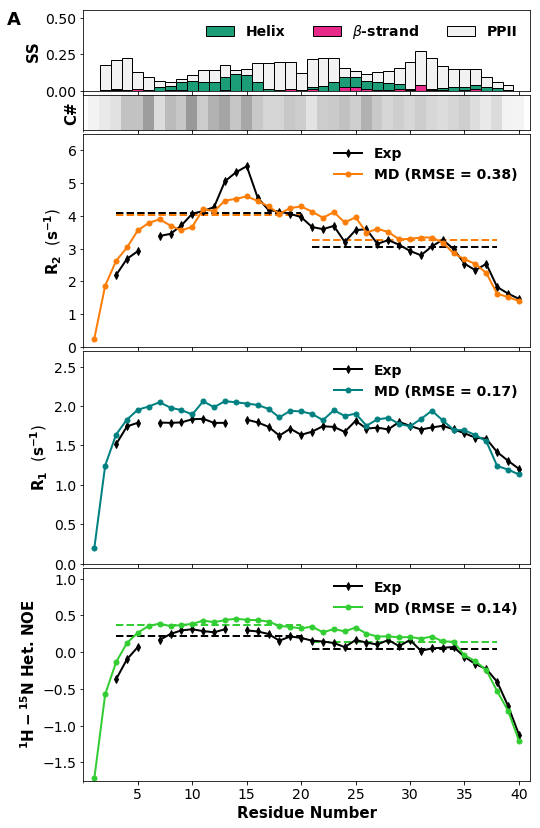

In [23]:
figNMR_Err, axNMR_Err = plt.subplots(5, 1, sharex=True, figsize=(8,14), 
                                     gridspec_kw={'height_ratios': [1, 0.5, 3,3,3]})
figNMR_Err.subplots_adjust(hspace=0.025)
RMSE_R1R2 = np.sqrt(NMRRelaxDF14_Scl1.iloc[1:-1][['R1_SE','R2_SE','NOE_SE']].mean())

#DSSP PLots
s3_bounds = axNMR_Err[0].get_position().bounds
axNMR_Err[0].axis('off')
axSS = figNMR_Err.add_axes([0.125, s3_bounds[1] + 0, s3_bounds[2], 0.08])
DSSP[[r'$\beta$-strand','Helix', 'PPII']].plot.bar(ax=axSS, color=SatCMap_SS_F3,
                                                linewidth=1, width=1.0, stacked=True, edgecolor='k', legend=False)
axSS.tick_params(labelsize=14)
axSS.set_xticks(np.arange(-1, DSSP.shape[0], 5), minor=False)
axSS.set_ylabel('SS', fontsize=15, weight='bold')
axSS.set_xticklabels([])
axSS.set_xlim(-1, DSSP.shape[0])
axSS.set_ylim(0, 0.55)
axSS.set_yticks(np.arange(0,0.55,0.25))

#get handles and labels
handles, labels = axSS.get_legend_handles_labels()

#specify order of items in legend
order = [1,0,2]

#add legend to plot
axSS.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc=1, prop={'size':14,'weight':'bold'}, ncol=3) 
#axSS.legend(frameon=False, loc=1, prop={'size':14,'weight':'bold'}, ncol=3)

axSS.text(-8,0.55,'A', weight='bold',fontsize=18, ha='left',va='top')


#Heatmap plot

ax_scsc = axNMR_Err[1]
#cbax_scsc = ax_scsc.add_axes([0.91, 0.125, 0.025, 0.755])
cmp_scsc = (con_map.values).reshape(40,1).T
cmp_scsc = np.insert(cmp_scsc, 0, 0).reshape(41,1).T
#hm_scsc = sns.heatmap(cmp_scsc, cmap='Blues', ax=ax_scsc, yticklabels=False, cbar=False, robust=False)


cmap = ax_scsc.imshow(cmp_scsc, cmap='Greys', aspect='auto', vmin=0, vmax=5)
ax_scsc.set_yticks([])
ax_scsc.set_xticklabels([])
ax_scsc.tick_params(labelsize=14)
ax_scsc.set_ylabel('C#', weight='bold', fontsize=15)



#ax_scsc.text(-7,-0.5,'B', weight='bold',fontsize=18, ha='left',va='top')

## R2 Plots
axR2 = axNMR_Err[2]


EXPNOEdf[['RESNUM','R2-Exp']].plot(x='RESNUM', y='R2-Exp',ax=axR2, color='k',
                                                label='Exp',
                                                linestyle='-', linewidth=2, marker='d', markersize=5)

NMRRelaxDF[['RESNUM','R2']].plot(x='RESNUM',y='R2', ax=axR2, color='#fb7d07',  
                                 label=r'MD (RMSE = {:.2})'.format(RMSE_R1R2['R2_SE']),
                                 linewidth=2, linestyle='-', marker='o', markersize=5)

#axR2.text(-7,6.40,'C', weight='bold',fontsize=18, ha='left',va='top')
axR2.set_ylabel(r'$\mathbf{R}_\mathbf{2} \ \ (\mathbf{s}^\mathbf{-1})$', weight='bold', fontsize=15)
axR2.legend(frameon=False, loc='best', prop={'size':14,'weight':'bold'})
axR2.tick_params(labelsize=14)
axR2.set_ylim(0,6.5)

axR2.hlines(y=NMRRelaxDF['R2'][3:20].mean(), xmin = 3, xmax = 20, linewidth=2, color ="#fb7d07", linestyle ="--")
axR2.hlines(y=NMRRelaxDF['R2'][20:38].mean(), xmin = 21, xmax = 38, linewidth=2, color ="#fb7d07", linestyle ="--")

axR2.hlines(y=EXPNOEdf['R2-Exp'][3:20].mean(), xmin = 3, xmax = 20, linewidth=2, color ="k", linestyle ="--")
axR2.hlines(y=EXPNOEdf['R2-Exp'][20:38].mean(), xmin = 21, xmax = 38, linewidth=2, color ="k", linestyle ="--")


##R1 Plots 
axR1 = axNMR_Err[3]

EXPNOEdf[['RESNUM','R1-Exp']].plot(x='RESNUM', y='R1-Exp',ax=axR1, color='k',
                                                label='Exp',
                                                linestyle='-', linewidth=2, marker='d', markersize=5)

NMRRelaxDF[['RESNUM','R1']].plot(x='RESNUM',y='R1', ax=axR1, color='teal', 
                                 label='MD (RMSE = {:.2})'.format(RMSE_R1R2['R1_SE']),
                                 linewidth=2, linestyle='-', marker='o', markersize=5)

axR1.set_ylim(0, 2.7)
#axR1.text(-7,2.60,'D', weight='bold',fontsize=18, ha='left',va='top')
axR1.set_ylabel(r'$\mathbf{R}_\mathbf{1} \ \ (\mathbf{s}^\mathbf{-1})$', weight='bold', fontsize=15)
axR1.legend(frameon=False, loc='best', prop={'size':14,'weight':'bold'})
axR1.tick_params(labelsize=14)


## NOE Plots
axNOE = axNMR_Err[4]

EXPNOEdf[['RESNUM','NOE-Exp']].plot(x='RESNUM', y='NOE-Exp', ax=axNOE, color='k',
                                                 label='Exp',
                                                  linestyle='-',ylim=(0.0,1.0), linewidth=2, marker='d', markersize=5)
NMRRelaxDF[['RESNUM','NOE']].plot(x='RESNUM',y='NOE', ax=axNOE, color='limegreen',
                                  label='MD (RMSE = {:.2})'.format(RMSE_R1R2['NOE_SE']),
                                  linewidth=2, linestyle='-' , marker='o', markersize=5)


#axNOE.text(-7,1.05,'E', weight='bold',fontsize=18, ha='left',va='top')
axNOE.set_ylabel(r'$\mathbf{^{1}H-^{15}N}$ Het. NOE', weight='bold', fontsize=15)
axNOE.set_xlabel('Residue Number', weight='bold', fontsize=15)
axNOE.set_ylim(-1.75,1.15)
axNOE.set_xlim(0,41)

axNOE.hlines(y=NMRRelaxDF['NOE'][3:20].mean(), xmin = 3, xmax = 20, linewidth=2, color ="limegreen", linestyle ="--")
axNOE.hlines(y=NMRRelaxDF['NOE'][20:38].mean(), xmin = 21, xmax = 38, linewidth=2, color ="limegreen", linestyle ="--")

axNOE.hlines(y=EXPNOEdf['NOE-Exp'][3:20].mean(), xmin = 3, xmax = 20, linewidth=2, color ="k", linestyle ="--")
axNOE.hlines(y=EXPNOEdf['NOE-Exp'][20:38].mean(), xmin = 21, xmax = 38, linewidth=2, color ="k", linestyle ="--")


axNOE.legend(frameon=False,loc=1,prop={'size':14,'weight':'bold'})
axNOE.set_xticks(np.arange(5,41,5))
axNOE.set_xticklabels(np.arange(5,41,5))
axNOE.tick_params(labelsize=14)

figNMR_Err.savefig('seq_dep_ab40_f_278.png',
              bbox_inches='tight',dpi=600)

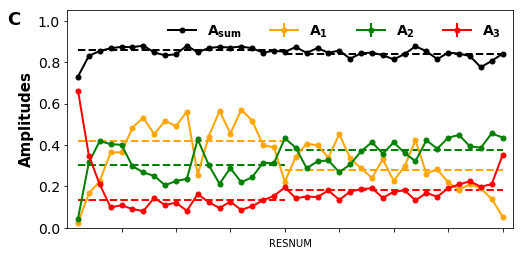

In [48]:
fig_f3 = plt.figure(131512, figsize=(8,4))
axf3 = plt.subplot(111)

#fig_f3, axf3 = plt.subplots(111, figsize=(8,8))
#fig_f3.subplots_adjust(hspace=0.05)
#ylim_t1=(1,8)
    
## Plot the Amplitudes to S1
NMRRelaxDF14_Scl1[['RESNUM','C_a','C_a_err']].plot(x='RESNUM', y='C_a', yerr='C_a_err', c='orange',
                                                ax=axf3, label=r'$\mathbf{A_1}$',
                                                linewidth=2, marker='o', linestyle='-', markersize=5)

NMRRelaxDF14_Scl1[['RESNUM','C_b','C_b_err']].plot(x='RESNUM', y='C_b', yerr='C_b_err', c='green',
                                                ax=axf3,  label=r'$\mathbf{A_2}$',
                                                linewidth=2, marker='o', linestyle='-', markersize=5)

NMRRelaxDF14_Scl1[['RESNUM','C_g','C_g_err']].plot(x='RESNUM', y='C_g', yerr='C_g_err', c='red',
                                                ax=axf3,  label=r'$\mathbf{A_3}$',
                                                linewidth=2, marker='o', linestyle='-', markersize=5)

NMRRelaxDF14_Scl1[['RESNUM','A_Total']].plot(x='RESNUM', y='A_Total', c='black',
                                                ax=axf3,  label=r'$\mathbf{A_{sum}}$',
                                                linewidth=2, marker='o', linestyle='-', markersize=5)

axf3.hlines(y=NMRRelaxDF14_Scl1['C_a'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="orange", linestyle ="--")
axf3.hlines(y=NMRRelaxDF14_Scl1['C_a'][20:40].mean(), xmin = 20, xmax = 40, linewidth=2, color ="orange", linestyle ="--")
#axf3.hlines(y=NMRRelaxDF14_Scl1['C_a'][96:140].mean(), xmin = 96, xmax = 140, linewidth=2, color ="orange", linestyle ="--")


#axf3.hlines(y=NMRRelaxDF14_Scl1['C_a'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="orange", linestyle ="--")

axf3.hlines(y=NMRRelaxDF14_Scl1['C_b'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="g", linestyle ="--")
axf3.hlines(y=NMRRelaxDF14_Scl1['C_b'][20:40].mean(), xmin = 20, xmax = 40, linewidth=2, color ="g", linestyle ="--")
#axf3.hlines(y=NMRRelaxDF14_Scl1['C_b'][96:140].mean(), xmin = 96, xmax = 140, linewidth=2, color ="g", linestyle ="--")


#axf3.hlines(y=NMRRelaxDF14_Scl1['C_b'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="g", linestyle ="--")

axf3.hlines(y=NMRRelaxDF14_Scl1['C_g'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="r", linestyle ="--")
axf3.hlines(y=NMRRelaxDF14_Scl1['C_g'][20:40].mean(), xmin = 20, xmax = 40, linewidth=2, color ="r", linestyle ="--")
#axf3.hlines(y=NMRRelaxDF14_Scl1['C_g'][96:140].mean(), xmin = 96, xmax = 140, linewidth=2, color ="r", linestyle ="--")

#axf3.hlines(y=NMRRelaxDF14_Scl1['C_g'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="r", linestyle ="--")

axf3.hlines(y=NMRRelaxDF14_Scl1['A_Total'][1:20].mean(), xmin = 1, xmax = 20, linewidth=2, color ="k", linestyle ="--")
axf3.hlines(y=NMRRelaxDF14_Scl1['A_Total'][20:40].mean(), xmin = 20, xmax = 40, linewidth=2, color ="k", linestyle ="--")
#axf3.hlines(y=NMRRelaxDF14_Scl1['A_Total'][96:140].mean(), xmin = 96, xmax = 140, linewidth=2, color ="k", linestyle ="--")


#axf3.hlines(y=NMRRelaxDF14_Scl1['A_Total'][20:40].mean(), xmin = 21, xmax = 40, linewidth=2, color ="k", linestyle ="--")


axf3.set_ylim(0, 1.05)
axf3.set_ylabel(r'Amplitudes', fontsize=15, weight='bold')

#axf3.set_xlabel('Residue Number', weight='bold', fontsize=15)
axf3.set_xlim(0,41)
##axf3.set_xlabel().remove()
axf3.legend(frameon=False,loc=0,prop={'size':14,'weight':'bold'}, ncol=4)
axf3.set_xticks(np.arange(5,41,5))
axf3.set_xticklabels(np.arange(5,41,5))

axf3.text(-5.5,1.05,'C', weight='bold',fontsize=18, ha='left',va='top')

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])

axf3.tick_params(labelsize=14)

fig_f3.savefig('amp_ab40.png',
              bbox_inches='tight',dpi=300)

In [19]:
print(NMRRelaxDF14_Scl1['tau_a'][1:39].mean())
print(NMRRelaxDF14_Scl1['tau_a'][1:39].std())

print(NMRRelaxDF14_Scl1['tau_b'][1:39].mean())
print(NMRRelaxDF14_Scl1['tau_b'][1:39].std())

print(NMRRelaxDF14_Scl1['tau_g'][1:39].mean())
print(NMRRelaxDF14_Scl1['tau_g'][1:39].std())

print(NMRRelaxDF14_Scl1['C_a'][1:39].mean())
print(NMRRelaxDF14_Scl1['C_a'][1:39].std())

print(NMRRelaxDF14_Scl1['C_b'][1:39].mean())
print(NMRRelaxDF14_Scl1['C_b'][1:39].std())

print(NMRRelaxDF14_Scl1['C_g'][1:39].mean())
print(NMRRelaxDF14_Scl1['C_g'][1:39].std())

print(NMRRelaxDF14_Scl1['A_Total'][1:39].mean())
print(NMRRelaxDF14_Scl1['A_Total'][1:39].std())

3.7892137507320967
0.6796891137453349
1.1158832859585863
0.30851629600493724
0.16825286356699165
0.04637662603980151
0.36324209848705546
0.12435910386618625
0.33308284387361536
0.07347984432002641
0.15275016768634417
0.05173960375505279
0.849075110047015
0.023427417871072033


In [58]:
NMRRelaxDF['R2'][12:17]

13    4.397094
14    4.448784
15    4.534719
16    4.388010
17    4.221160
Name: R2, dtype: float64

In [59]:
EXPNOEdf['R2-Exp'][12:17]

13    5.052344
14    5.322938
15    5.513787
16    4.557665
17    4.174441
Name: R2-Exp, dtype: float64

In [63]:
NMRRelaxDF['R2'][28:35]

29    3.207238
30    3.232879
31    3.259598
32    3.248675
33    3.105522
34    2.777001
35    2.594705
Name: R2, dtype: float64

In [62]:
EXPNOEdf['R2-Exp'][28:35]

29    3.115951
30    2.927632
31    2.796211
32    3.064573
33    3.271341
34    2.985330
35    2.541146
Name: R2-Exp, dtype: float64

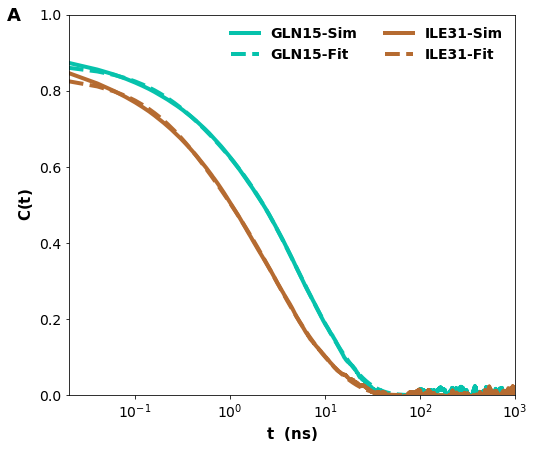

In [29]:
figExDecays, axExDecays = plt.subplots(1,1,figsize=(8,7))
figExDecays.subplots_adjust(hspace=0.275, wspace=0.275)

RESExamples = ['GLN14-NH', 'ILE30-NH']
ind_re = [np.where(NMRRelaxDF14_Scl1['Resname']==RE)[0][0] for RE in RESExamples]
x = CtDF14.index.values
Example_Model_DF = pd.DataFrame(index=x, columns=RESExamples)

for RE in RESExamples:
    ind_re = np.where(FitDF1['Resname']==RE)[0][0]
    Example_Model_DF.loc[:,RE]  = func_exp_decay6(x, *FitDF1.iloc[ind_re][['C_a','tau_a','C_b','tau_b','C_g','tau_g']].values)

clist = ['#06c2ac', '#85440a', '#7b0323']
clist2 = ['#06c2ac', '#b56b31', '#7b0323']

for RES, cl in zip(RESExamples, clist2[:-1]):
    
    update_resname = pd.Series(RES.split('-')[0]).str.extract('([A-Z]+)([0-9]+)')
    CtDF14[RES].plot.line(grid=False, xlim=(0.02, 1000), logx=True, color=cl,
                             ylim=(0.0, 1.0), ax=axExDecays, 
                          label = '{}-Sim'.format(update_resname.loc[0,0]+str((int(update_resname.loc[0,1])+1))) , 
                          linestyle='-', linewidth=4)
    Example_Model_DF[RES].plot.line(grid=False, xlim=(0.02, 1000), color=cl, logx=True, ylim=(0.0, 1.2), 
                            ax=axExDecays, 
                            label = '{}-Fit'.format(update_resname.loc[0,0]+str((int(update_resname.loc[0,1])+1))),
                            linestyle='--', linewidth=4)
    
    axExDecays.set_ylim((0,0.8))
    axExDecays.set_yticks(np.arange(0.0,1.1,0.2))
        
    axExDecays.set_ylabel(r'$\mathbf{C(t)}$',fontsize=15)
    axExDecays.set_xlabel(r'$\mathbf{t \ \ (ns)}$', fontsize=15)
    
    axExDecays.legend(frameon=False, loc=1, prop={'size':14,'weight':'bold'}, ncol=2)
    
    axExDecays.set_xticks([],minor=True)
    axExDecays.xaxis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
    
    
    axExDecays.tick_params(labelsize=14)
    
#    list(axExDecays.spines.values())[1].set_visible(False)
#    list(axExDecays.spines.values())[3].set_visible(False)

plt.text(0.0045,1.02,'A', weight='bold',fontsize=18, ha='left',va='top')

plt.savefig('ab40_Ct_fit.png', bbox_inches='tight',dpi=600)